# Time Series Analysis with GridDB and Python

In this tutorial, we will see how to analyze time-series data stored in GridDB using Python. The outline of the tutorial is as follows - 
1. Loading the dataset using SQL and Pandas
2. Preprocess the data to deal with null, missing values, etc.
3. Build a classifier for our data

## Prerequisites

This tutorial assumes prior installation of GridDB, Python3, and the associated libraries. If you have not installed any of the below packages, go ahead and do it before continuing with the tutorial.
1. [GridDB](https://griddb.net/en/)
2. [Python 3](https://www.python.org/downloads/)
3. [GridDB Python Client](https://github.com/griddb/python_client)
4. [NumPy](https://numpy.org/)
5. [Pandas](https://pandas.pydata.org/)
6. [Matplotlib](https://matplotlib.org/)
7. [Scikit-learn](https://scikit-learn.org/stable/)
8. [Lightgbm](https://pypi.org/project/lightgbm/)
9. [Seaborn](https://seaborn.pydata.org/#)

The following tutorial is carried out in [Jupyter notebooks (Anaconda Navigator)](https://www.anaconda.com/). You can install these packages directly in your environment using <code>conda install package_name</code>. Alternatively, type <code>pip install package_name</code> in the command prompt/terminal. 

## Importing the necessary libraries

Once you are done installing the required packages, let's import these libraries.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
import os
from datetime import datetime
import time
from lightgbm import LGBMRegressor
import seaborn as sns
from sklearn import metrics

In [2]:
APP_PATH = os.getcwd()
APP_PATH

'C:\\Users\\SHRIPRIYA\\Desktop\\AW Group\\GridDB'

## Loading the dataset

The time-series dataset we're using for this tutorial has been open-sourced on [Kaggle](https://www.kaggle.com/vetrirah/ml-iot). The zip folder contains two separate files for training and testing. However, since the test dataset does not contain the labels, we will not be able to verify our model's performance. Therefore, will be using the training file as the whole dataset, and later on, we will split it into Train and Test sets. 

The training file has about 48000 rows (or instances) with 4 columns (or attributes) - <code>ID, DateTime, Junction, and Vehicles</code>. Column <code>Vehicle</code> is the dependent (or response) variable while <code>DateTime and Junction</code> are independent (or explanatory) variables

## Using SQL 

You can type the following statement in your Python script or console to retrieve the data from [GridDB](https://griddb.net/). The advantage of using GridDB's [python-client](https://github.com/griddb/python_client) is that the resulting data type is a pandas dataframe. This makes data manipulation much easier. 

<code>statement = ('SELECT * FROM train_ml_iot')
dataset = pd.read_sql_query(statement, cont)</code>

The output will look like - 

<img src="dataset_sql_query.png">

## Using Pandas

Don't worry if you're not using GridDB. You could still load the dataset using Pandas. Note that this is an alternative to the previous step. You don't need to do both steps. 

In [3]:
dataset = pd.read_csv(os.path.join(APP_PATH, 'train_ML_IOT.csv'))

## Getting to know the dataset

Now that we have loaded our dataset, it is time to get a peek at how it looks. We can print out the first 5 rows using the <code>head</code> command. If you want to print more rows, simply pass a number to the function as an argument. For instance, <code>dataset.head(15)</code> will print out the first 15 rows. You can also use the <code>tail</code> command to get a gist of the dataset. The only difference is, as the name suggests, it prints the last 5 rows. 

In [4]:
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [5]:
len(dataset)

48120

<code>describe()</code> command is useful when dealing with numerical data. It basically prints out the whole summary of your data such as <code>min, max, average</code>, etc. We can use this information to know the range and scale of each attribute. There does not seem any anomaly from this level. Also, the scale of the attributes is not that different. This means we can skip the feature scaling step for this dataset.

In [6]:
dataset.describe()

,Junction,Vehicles,ID
count,48120.000000,48120.000000,4.812000e+04
mean,2.180549,22.791334,2.016330e+10
std,0.966955,20.750063,5.944854e+06
min,1.000000,1.000000,2.015110e+10
25%,1.000000,9.000000,2.016042e+10
50%,2.000000,15.000000,2.016093e+10
75%,3.000000,29.000000,2.017023e+10
max,4.000000,180.000000,2.017063e+10


## Data Preprocessing

As mentioned above, the two attributes - <code>DateTime and Junction</code> are the independent variables and therefore, contribute to the outcome variable i.e.<code>Vehicles</code>. Therefore, keeping the <code>ID</code> attribute seems unnecessary. Let's go ahead and drop it.

In [7]:
dataset.drop(["ID"],axis = 1,inplace=True)

Nobody likes redundant data. Let's drop that too!

In [8]:
dataset.drop_duplicates(keep="first", inplace=True)
len(dataset)

48120

Fortunately, the dataset did not have any duplicates, but it's always a good practice to check for redundancy. Dealing with null values is also important when dealing with numerical data, especially. Null values make it difficult to perform mathematical operations and can also result in errors. So, you either replace null values with dummy data or drop those rows. Let's first check if our data contains any null values.

In [9]:
dataset.isnull().sum()

DateTime    0
Junction    0
Vehicles    0
dtype: int64

In [10]:
dataset.dtypes

DateTime    object
Junction     int64
Vehicles     int64
dtype: object

The <code>DateTime</code> attribute has the datatype <code>object</code>. We will first call the pandas function <code>to_datetime</code> to convert this attribute to its actual format. This will allow us to extract the information about the <code>year, month, day</code>, etc, directly. 

In [11]:
dataset['DateTime'] = pd.to_datetime(dataset['DateTime'])

Great! Now that our time is converted to a suitable format, let's extract the following attributes - <code>Weekday, Year, Month, Day, Time, Week, and Quater</code>

In [12]:
dataset['Weekday'] = [date.weekday() for date in dataset.DateTime]
dataset['Year'] = [date.year for date in dataset.DateTime]
dataset['Month'] = [date.month for date in dataset.DateTime]
dataset['Day'] = [date.day for date in dataset.DateTime]
dataset['Time'] = [((date.hour*60+(date.minute))*60)+date.second for date in dataset.DateTime]
dataset['Week'] = [date.week for date in dataset.DateTime]
dataset['Quarter'] = [date.quarter for date in dataset.DateTime]

The updated dataset looks like - 

In [13]:
dataset.head()

,DateTime,Junction,Vehicles,Weekday,Year,Month,Day,Time,Week,Quarter
0,2015-11-01 00:00:00,1,15,6,2015,11,1,0,44,4
1,2015-11-01 01:00:00,1,13,6,2015,11,1,3600,44,4
2,2015-11-01 02:00:00,1,10,6,2015,11,1,7200,44,4
3,2015-11-01 03:00:00,1,7,6,2015,11,1,10800,44,4
4,2015-11-01 04:00:00,1,9,6,2015,11,1,14400,44,4


In [14]:
dataset.keys()

Index(['DateTime', 'Junction', 'Vehicles', 'Weekday', 'Year', 'Month', 'Day',
       'Time', 'Week', 'Quarter'],
      dtype='object')

## Visualizing the trend

Let's see if there are any patterns our data is following.  

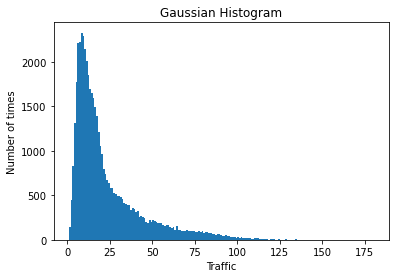

In [15]:
data = dataset.Vehicles
binwidth = 1
plt.hist(data, bins=range(min(data), max(data) + binwidth, binwidth), log=False)
plt.title("Gaussian Histogram")
plt.xlabel("Traffic")
plt.ylabel("Number of times")
plt.show()

We can see that, more often than not, the traffic lies between <code>(20,30)</code> given a certain timestamp. That's not too bad. 

## Preparing the dataset for Model Building

The <code>datetounix</code> function converts the <code>DateTime</code> attribute to <code>unixtime</code>. A <code>unix timestamp</code> is simply a number denoting the total time elapsed (in seconds) since the Unix Epoch. As its definition suggests, a <code>unix timestamp</code> is timezone independent which is why it is frequently used during Model Building.  

In [16]:
def datetounix(df):
    unixtime = []
    
    # Running a loop for converting Date to seconds
    for date in df['DateTime']:
        unixtime.append(time.mktime(date.timetuple()))
    
    # Replacing Date with unixtime list
    df['DateTime'] = unixtime
    return(df)

In [17]:
dataset_features = datetounix(dataset)

In [18]:
dataset_features

,DateTime,Junction,Vehicles,Weekday,Year,Month,Day,Time,Week,Quarter
0,1.446316e+09,1,15,6,2015,11,1,0,44,4
1,1.446320e+09,1,13,6,2015,11,1,3600,44,4
2,1.446323e+09,1,10,6,2015,11,1,7200,44,4
3,1.446327e+09,1,7,6,2015,11,1,10800,44,4
4,1.446331e+09,1,9,6,2015,11,1,14400,44,4
...,...,...,...,...,...,...,...,...,...,...
48115,1.498829e+09,4,11,4,2017,6,30,68400,26,2
48116,1.498833e+09,4,30,4,2017,6,30,72000,26,2
48117,1.498837e+09,4,16,4,2017,6,30,75600,26,2
48118,1.498840e+09,4,22,4,2017,6,30,79200,26,2


In [19]:
X = dataset_features  

<code>Junction, Weekday, and Day</code> are discrete data - they are classes rather than a continuous value. Therefore, we need to encode this data before passing it to the classifier. For that, these data will need to be converted to <code>str</code>. Then, we will call the <code>get_dummies</code> function to get the encoded data.  

In [20]:
X['Junction'] = X['Junction'].astype('str')
X['Weekday']  = X['Weekday'].astype('str')
X['Day'] = X[ 'Day' ].astype('str')

In [21]:
X = pd.get_dummies(X)

In [22]:
print("X.shape : ", X.shape)
display(X.columns)

X.shape :  (48120, 49)


Index(['DateTime', 'Vehicles', 'Year', 'Month', 'Time', 'Week', 'Quarter',
       'Junction_1', 'Junction_2', 'Junction_3', 'Junction_4', 'Weekday_0',
       'Weekday_1', 'Weekday_2', 'Weekday_3', 'Weekday_4', 'Weekday_5',
       'Weekday_6', 'Day_1', 'Day_10', 'Day_11', 'Day_12', 'Day_13', 'Day_14',
       'Day_15', 'Day_16', 'Day_17', 'Day_18', 'Day_19', 'Day_2', 'Day_20',
       'Day_21', 'Day_22', 'Day_23', 'Day_24', 'Day_25', 'Day_26', 'Day_27',
       'Day_28', 'Day_29', 'Day_3', 'Day_30', 'Day_31', 'Day_4', 'Day_5',
       'Day_6', 'Day_7', 'Day_8', 'Day_9'],
      dtype='object')

In [23]:
X.head()

,DateTime,Vehicles,Year,Month,Time,Week,Quarter,Junction_1,Junction_2,Junction_3,...,Day_29,Day_3,Day_30,Day_31,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9
0,1.446316e+09,15,2015,11,0,44,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.446320e+09,13,2015,11,3600,44,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.446323e+09,10,2015,11,7200,44,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.446327e+09,7,2015,11,10800,44,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.446331e+09,9,2015,11,14400,44,4,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## Defining a classifier

We will be using a gradient boosting model - <code>LGBMRegressor</code>. More information on the model architecture and parameters can be found [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMRegressor.html).  

In [24]:
clf = LGBMRegressor(boosting_type='gbdt',
                    max_depth=6,
                    learning_rate=0.25, 
                    n_estimators=80, 
                    min_split_gain=0.7,
                    reg_alpha=0.00001,
                    random_state = 16
                   )


## Splitting the dataset

Splitting the dataset into train and test with a ratio of 70-30. You can customize this ratio as per your convenience. We have used the conventional one.

In [25]:
Y = dataset['Vehicles'].to_frame()
dataset = dataset.drop(['Vehicles'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=101)

## Model Evaluation

Let's see how our model performs on the test data.

In [26]:
clf = clf.fit(X_train, y_train)

In [27]:
predictions = clf.predict(X_test)

In [28]:
print("RMSE", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

RMSE 0.309624242642493


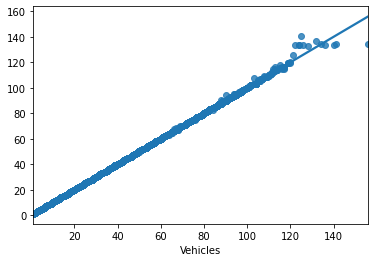

In [29]:
sns.regplot(y_test,predictions)

## Conclusion

The model resulted in an RMSE of <code>0.309</code> which is pretty decent. You could try experimenting with different evaluation metrics. The resulting line in the plot seems to fit the data instances accurately. Thus, we could be assured that the model is performing well. 

More information on Metrics and Scoring is available on the [official website of scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html). Happy Coding!